# Generate Agricultural Index Time Series

In this guide, you will learn how to:

1. Create and post Statistical API requests to calculate agricultural indices
2. Use Statistical API responses with Python libraries like `pandas`, `Matplotlib`, `tslearn`, and `ipyleaflet`
3. Process and analyze time series data further in Python by doing additional data cleanup, clustering, and calculating area under the curve


<div style="width: 75%; padding: 15px; border: 2px solid #007980; border-radius: 5px; background-color: transparent; margin-left: 0;">
  <div style="display: flex; justify-content: space-between; align-items: center;">
    <div style="display: flex; align-items: center; flex: 0 0 50%; padding-right: 20px;">
      <svg style="margin-right: 10px; fill: #007980; width: 64px; height: 64px;" viewBox="0 0 24 24">
        <path d="M11,9H13V7H11M12,20C7.59,20 4,16.41 4,12C4,7.59 7.59,4 12,4C16.41,4 20,7.59 20, 12C20,16.41 16.41,20 12,20M12,2A10,10 0 0,0 2,12A10,10 0 0,0 12,22A10,10 0 0,0 22,12A10, 10 0 0,0 12,2M11,17H13V11H11V17Z"></path>
      </svg>
      <p style="font-size: 16px; margin: 0; line-height: 1.5;">
        This notebook makes use of <a href="https://collections.sentinel-hub.com/planet-sandbox-data/" target="_blank">Planet Sandbox Data</a>. You need a Planet account in order to access this data. If you don't already have an account, you can <a href="https://www.sentinel-hub.com/create_account/" target="_blank">create a free 30 day trial</a>.
      </p>
    </div>
    <div style="flex: 0 0 50%; display: flex; justify-content: center; align-items: center;">
      <a href="https://www.sentinel-hub.com/create_account/" target="_blank" style="
        display: inline-block;
        padding: 10px 20px;
        font-size: 16px;
        font-weight: bold;
        color: #fff;
        background-color: #007980;
        border-radius: 5px;
        text-decoration: none;
        white-space: nowrap;
        transition: background-color 0.3s ease;
        margin: 0 auto;
      " onmouseover="this.style.backgroundColor='#005960'" onmouseout="this.style.backgroundColor='#007980'">
        Start Free Trial
      </a>
    </div>
  </div>
</div>


## Import Packages

In [2]:
from datetime import timezone, datetime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import pandas as pd
import numpy as np
import getpass
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans

from sentinelhub import (
    CRS,
    DataCollection,
    Geometry,
    SentinelHubStatistical,
    SentinelHubStatisticalDownloadClient,
    SHConfig,
    BBox,
    SentinelHubRequest,
    MimeType
)

import warnings
warnings.filterwarnings('ignore')


## Credentials

The Sentinel Hub Python SDK requires a `client_id` and a `client_secret` which can be created in the [Dashboard app user settings](https://apps.sentinel-hub.com/dashboard/#/account/settings). You can find full instructions on setting up the client credentials in this SDK from the [SDK documentation](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). The following code will check if you have a local profile already created, and if not it will ask for the credentials and save the profile.

In [3]:
config = SHConfig()

if not config.sh_client_id or not config.sh_client_secret:
    print("No credentials found, please provide the OAuth client ID and secret.")
    config.sh_client_id = getpass.getpass("Client ID: ")
    config.sh_client_secret = getpass.getpass("Client Secret: ")
    config.save()
    print(f"Credentials saved to {SHConfig.get_config_location()}")
else:
    print(f"Connected to Sentinel Hub")

Connected to Sentinel Hub


##### Provide Areas of Interest

To create our Statistical API requests, we need to specify the areas where we want statistics to be calculated. In this example, we will be using agricultural fields located in Sinaloa, Mexico.

In this area, there is [Planet Sandbox Data available for PlanetScope](https://docs.planet.com/data/imagery/planetscope/sandbox/).  You can use this data immediately without ordering for learning how to use the platform.

In [4]:
# Read the fields from a GeoJSON file
agriculture_fields = gpd.read_file("agriculture_fields.geojson")

# Get the bounding box of the GeoDataFrame
minx, miny, maxx, maxy = agriculture_fields.total_bounds
bbox = BBox((minx, miny, maxx, maxy), crs=CRS.WGS84)

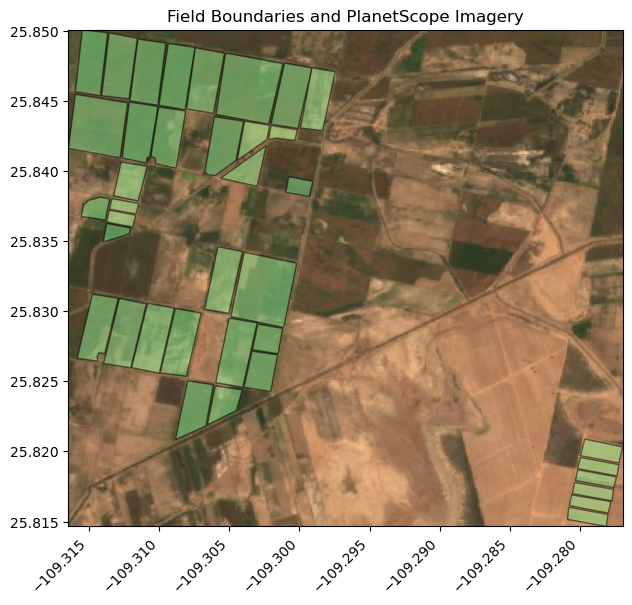

In [5]:
evalscript = """
//VERSION=3
//True Color
function setup() {
  return {
    input: ["blue", "green", "red", "dataMask"],
    output: { bands: 4 }
  };
}
function evaluatePixel(sample) {
  return [sample.red / 3000, sample.green / 3000, sample.blue / 3000, sample.dataMask];
}
"""

request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.define_byoc('ccb1f8f0-e5bf-4c31-afe5-d8803bcbde2a'),
            time_interval=('2022-05-12', '2022-05-12')
        )
    ],
    responses=[SentinelHubRequest.output_response('default', MimeType.JPG)],
    bbox=bbox,
    resolution=(0.0001, 0.0001),
    config=config
)

image = request.get_data()[0] 

fig, ax = plt.subplots(figsize=(8, 6))

ax.imshow(image, extent=(minx, maxx, miny, maxy), origin='upper')

agriculture_fields.plot(
    ax=ax,
    color='lightgreen',
    edgecolor='black',
    alpha=0.5
)

ax.set_aspect('equal')
ax.ticklabel_format(useOffset=False, style='plain')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
ax.set_title("Field Boundaries and PlanetScope Imagery")

plt.show()

## Set up Statistical API Request Parameters

In [22]:
# PlanetScope Sandbox Data Collection
collection_id = "ccb1f8f0-e5bf-4c31-afe5-d8803bcbde2a"
planetscope_data_collection = DataCollection.define_byoc(collection_id)
input_data = SentinelHubStatistical.input_data(planetscope_data_collection)

# Set a time interval
start_time = datetime(2022, 5, 1, tzinfo=timezone.utc)
end_time = datetime(2023, 4, 30, tzinfo=timezone.utc)
time_interval = start_time.strftime('%Y-%m-%d'), end_time.strftime('%Y-%m-%d')

# Specify a resolution - in the units of the provided areas of interest, in this case EPSG:4326
# This is the imagery resolution that will be used to perform the analysis.  
# You can use a resolution closer to native pixel size, or use lower resolution to run the analysis faster with downsampled data.
resx = 3e-05
resy = 3e-05

# Provide an evalscript which determines what statistics should be calculated
# This evalscript calculates several vegetation indices including NDVI, MSAVI, NDRE, and RTVICore

evalscript = """
//VERSION=3
//PlanetScope Mutliple Agricultural Indices

function setup() {
  return {
    input: [{
      bands: [
        "nir",
        "rededge",
        "dataMask",
        "green",
        "red",
        "clear"
      ]
    }],
    output: [
      { id: "ndre", bands: 1, sampleType: "FLOAT32" },
      { id: "ndvi", bands: 1, sampleType: "FLOAT32" },
      { id: "rtvicore", bands: 1, sampleType: "FLOAT32" },
      { id: "msavi", bands: 1, sampleType: "FLOAT32" },
      { id: "dataMask", bands: 1 },
    ]
  }
}

function evaluatePixel(sample) {

  let ndre = index(sample.nir, sample.rededge);

  let ndvi = index(sample.nir, sample.red);

  let msavi = 0.5 * (2.0 * sample.nir + 1 - (((2 * sample.nir + 1) ** 2) - 8 * (sample.nir - sample.red)) ** 0.5)

  let rtvicore = (100 * (sample.nir - sample.rededge) - 10 * (sample.nir - sample.green))

  let is_nodata = sample.dataMask == 0 || sample.clear == 0;
  let mask = is_nodata ? 0 : 1;

  return {
    ndre: [ndre],
    ndvi: [ndvi],
    rtvicore: [rtvicore],
    msavi: [msavi],
    dataMask: [mask],
  };
}
"""

# Feed the data into an aggregation, and specify the aggregation interval as P1D for daily statistics
aggregation = SentinelHubStatistical.aggregation(
    evalscript=evalscript, time_interval=time_interval, aggregation_interval="P1D", resolution=(resx, resy)
)

In [23]:
# For each agriculture field boundary, create a Statistical API request

stats_requests = []

for geo_shape in agriculture_fields.geometry.values:
    request = SentinelHubStatistical(
        aggregation=aggregation,
        input_data=[input_data],
        geometry=Geometry(geo_shape, crs=CRS("EPSG:4326")),
        config=config,
    )
    stats_requests.append(request)
    
print("{} Statistical API requests prepared!".format(len(stats_requests)))

38 Statistical API requests prepared!


## Submit the Statistical API Requests

With the provided example, this should take ~3 minutes to process all of the data in Planet Insights Platform. This request is taking 365 days worth of PlanetScope data across 38 agriculture fields and calculating several indices for each, that's 10's of thousands of datapoints being generated on-demand. All of this data crunching is happening in the cloud so you can do large scale analysis from anywhere, without downloading the source imagery. In return, we'll get back statistics that we can use to do further analysis in our local Python environment.

<div class="alert alert-block alert-info">
<b>Processing Units:</b> The following code block will consume processing units.
</div>

In [24]:
%%time

download_requests = [stats_request.download_list[0] for stats_request in stats_requests]

client = SentinelHubStatisticalDownloadClient(config=config)

stats_responses = client.download(download_requests, show_progress=True)

print("{} Results from the Statistical API!".format(len(stats_responses)))

  0%|          | 0/38 [00:00<?, ?it/s]

38 Results from the Statistical API!
CPU times: total: 1.78 s
Wall time: 1min 30s


We can also parse the response headers to extract information about how many processing units were used for the analysis.

To do this, we must pass the `decode_data = False` parameter.  The data will be returned as binary with response headers.

Data can be subsequently decoded with `decode()`.

Below is a single field which consumed ~60 processing units for this analysis.

In [25]:
one_request = stats_requests[0].get_data(decode_data=False)

decoded_data = one_request[0].decode()["data"]

pd.json_normalize(decoded_data).head(100)

,interval.from,interval.to,outputs.ndre.bands.B0.stats.min,outputs.ndre.bands.B0.stats.max,outputs.ndre.bands.B0.stats.mean,outputs.ndre.bands.B0.stats.stDev,outputs.ndre.bands.B0.stats.sampleCount,outputs.ndre.bands.B0.stats.noDataCount,outputs.ndvi.bands.B0.stats.min,outputs.ndvi.bands.B0.stats.max,...,outputs.msavi.bands.B0.stats.mean,outputs.msavi.bands.B0.stats.stDev,outputs.msavi.bands.B0.stats.sampleCount,outputs.msavi.bands.B0.stats.noDataCount,outputs.rtvicore.bands.B0.stats.min,outputs.rtvicore.bands.B0.stats.max,outputs.rtvicore.bands.B0.stats.mean,outputs.rtvicore.bands.B0.stats.stDev,outputs.rtvicore.bands.B0.stats.sampleCount,outputs.rtvicore.bands.B0.stats.noDataCount
0,2022-05-01T00:00:00Z,2022-05-02T00:00:00Z,0.109923,0.466993,0.311215,0.058146,16072,5519,0.169545,0.688226,...,0.643436,0.09383,16072,5519,41590.0,217710.0,128664.475505,27930.207605,16072,5519
1,2022-05-02T00:00:00Z,2022-05-03T00:00:00Z,0.112909,0.472009,0.315311,0.060495,16072,5519,0.14918,0.707906,...,0.648532,0.099087,16072,5519,44170.0,212260.0,127352.386051,27918.210305,16072,5519
2,2022-05-03T00:00:00Z,2022-05-04T00:00:00Z,0.108567,0.458551,0.309238,0.059519,16072,5519,0.163848,0.687444,...,0.639958,0.097222,16072,5519,39080.0,218130.0,131926.70994,27514.253565,16072,5519
3,2022-05-04T00:00:00Z,2022-05-05T00:00:00Z,0.096986,0.46461,0.317637,0.063109,16072,5519,0.154895,0.699853,...,0.656355,0.098767,16072,5519,34270.0,192560.0,117583.8264,25274.356137,16072,5519
4,2022-05-05T00:00:00Z,2022-05-06T00:00:00Z,0.091297,0.463415,0.311637,0.060582,16072,5519,0.149676,0.684092,...,0.634991,0.097341,16072,5519,30780.0,208950.0,126301.326637,26364.746586,16072,5519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2022-09-15T00:00:00Z,2022-09-16T00:00:00Z,0.122264,0.546024,0.41078,0.08503,16072,5519,0.184172,0.761694,...,0.728382,0.110654,16072,5519,45960.0,251230.0,162897.443381,39112.541565,16072,5519
96,2022-09-16T00:00:00Z,2022-09-17T00:00:00Z,0.114736,0.582049,0.433609,0.091431,16072,5519,0.192348,0.76573,...,0.733975,0.113444,16072,5519,48600.0,270350.0,181724.755994,37629.623808,16072,5519
97,2022-09-17T00:00:00Z,2022-09-18T00:00:00Z,0.105628,0.537167,0.395472,0.086759,16072,5519,0.163053,0.751498,...,0.715653,0.117247,16072,5519,47350.0,240150.0,162673.797972,34719.79353,16072,5519
98,2022-09-18T00:00:00Z,2022-09-19T00:00:00Z,0.120806,0.557519,0.379489,0.081594,16072,5519,0.174648,0.697121,...,0.677968,0.108293,16072,5519,57000.0,260520.0,171564.99005,35442.966107,16072,5519


In [26]:
[print(key, ":", value) for key, value in one_request[0].headers.items()]

print("\n-----\nProcessing units spent:", one_request[0].headers["x-processingunits-spent"])

Date : Mon, 24 Mar 2025 15:17:54 GMT
Content-Type : application/json;charset=utf-8
Transfer-Encoding : chunked
Connection : keep-alive
access-control-allow-origin : *
access-control-allow-headers : origin,content-type,accept,accept-crs,authorization,cache-control
access-control-allow-credentials : true
access-control-allow-methods : GET, POST, PUT, DELETE, OPTIONS, HEAD, PATCH
access-control-max-age : 3600
x-processingunits-spent : 54.97446564894199

-----
Processing units spent: 54.97446564894199


Back to our analysis, now that we have our data!

Now we can convert the JSON response from the Statistical API into a `pandas` DataFrame. The table will have the following columns:

| column    | definition |
| -------- | ------- |
| ndre mean | The mean value for the Normalized Difference Red Edge Index |
| ndvi mean    | The mean value for the Normalized Difference Vegetation Index |
| msavi mean | The mean value for the Modified Soil Adjusted Vegetation Index |
| rtvicore mean | The mean value for the Red-Edge Triangulated Vegetation Index |
| date| The date of the observation |
| day_of_year | The day number within a year |
| field_id | The index value from the input geojson field boundaries file |

In [27]:
# Normalize the JSON responses into a list of pandas dataframes
stats_df_list = [pd.json_normalize(per_aoi_stats["data"]) for per_aoi_stats in stats_responses]

# Add the ID from the input geojson file so we know which field goes with which statistics
for df, oid in zip(stats_df_list, agriculture_fields.index):
    df["field_id"] = oid

# Combine all of the dataframes into a single dataframe
stats_df = pd.concat(stats_df_list, ignore_index=True)

# Add date and day_of_year columns
stats_df["date"] = pd.to_datetime(stats_df['interval.from']).dt.date
stats_df["day_of_year"] = stats_df.apply(lambda row: row["date"].timetuple().tm_yday, axis=1)

# Filter and rename the columns to keep only the mean values
mean_columns = [col for col in stats_df.columns if '.mean' in col]
stats_df = stats_df[mean_columns + ["date", "day_of_year", "field_id"]]

# Rename columns to keep only the unique part
renamed_columns = {col: col.split('.')[1] + ' mean' for col in mean_columns}
stats_df = stats_df.rename(columns=renamed_columns)

# Convert mean columns to floats
for col in renamed_columns.values():
    stats_df[col] = pd.to_numeric(stats_df[col], errors='coerce')

# Display the filtered and renamed dataframe
stats_df

,ndre mean,ndvi mean,msavi mean,rtvicore mean,date,day_of_year,field_id
0,0.311215,0.480811,0.643436,128664.475505,2022-05-01,121,0
1,0.315311,0.487133,0.648532,127352.386051,2022-05-02,122,0
2,0.309238,0.477453,0.639958,131926.709940,2022-05-03,123,0
3,0.317637,0.495788,0.656355,117583.826400,2022-05-04,124,0
4,0.311637,0.472008,0.634991,126301.326637,2022-05-05,125,0
...,...,...,...,...,...,...,...
10210,0.407050,0.529242,0.666523,173179.459530,2023-04-25,115,37
10211,0.397682,0.509910,0.645513,165551.370757,2023-04-26,116,37
10212,0.413853,0.529537,0.663117,165408.093995,2023-04-27,117,37
10213,0.419630,0.517747,0.652466,157968.503916,2023-04-28,118,37


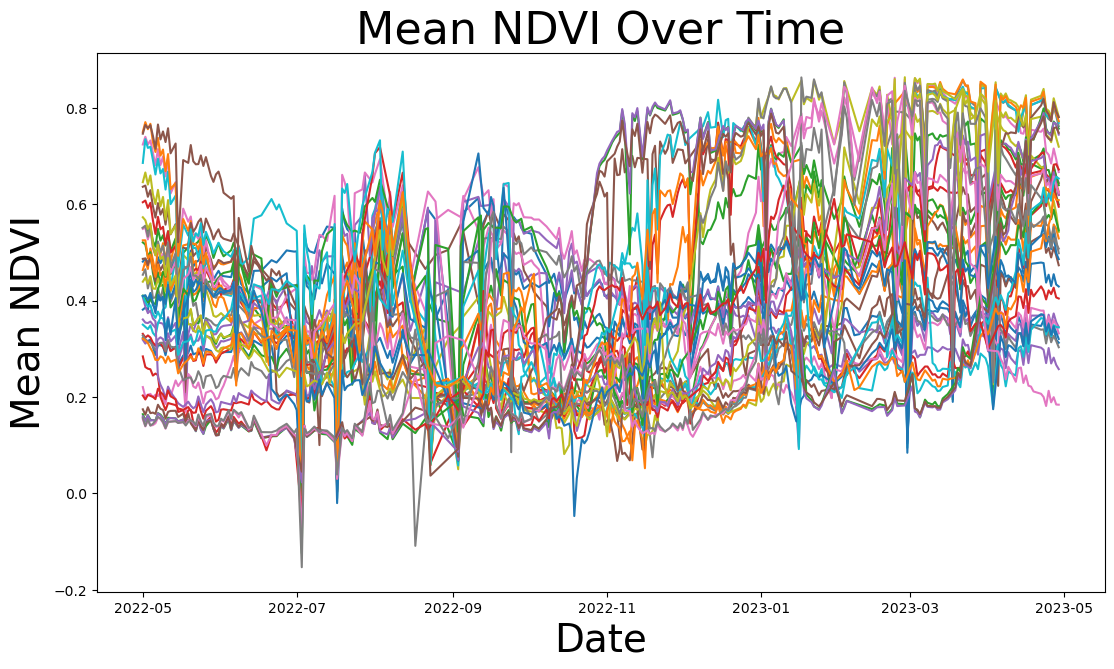

In [28]:
# Ensure numeric types and handle NaN values
stats_df = stats_df.dropna(subset=["ndvi mean"])

fig, ax = plt.subplots(figsize=(13, 7))

for idx, field_id in enumerate(agriculture_fields.index):

    series = stats_df[(stats_df["field_id"] == field_id)]
            
    series.plot(ax=ax, x="date", y="ndvi mean", legend=False)

title = ax.set_title('Mean NDVI Over Time', fontsize=32)
ylabel = ax.set_ylabel("Mean NDVI", fontsize=28)
xlabel = ax.set_xlabel("Date", fontsize=28)

plt.show()

Let's focus in on just one field, and look at the other spectral indices.  Different indices may have more applicability to different regions, crops, or parts of the growing season.

Visualizing the chart for field number 29


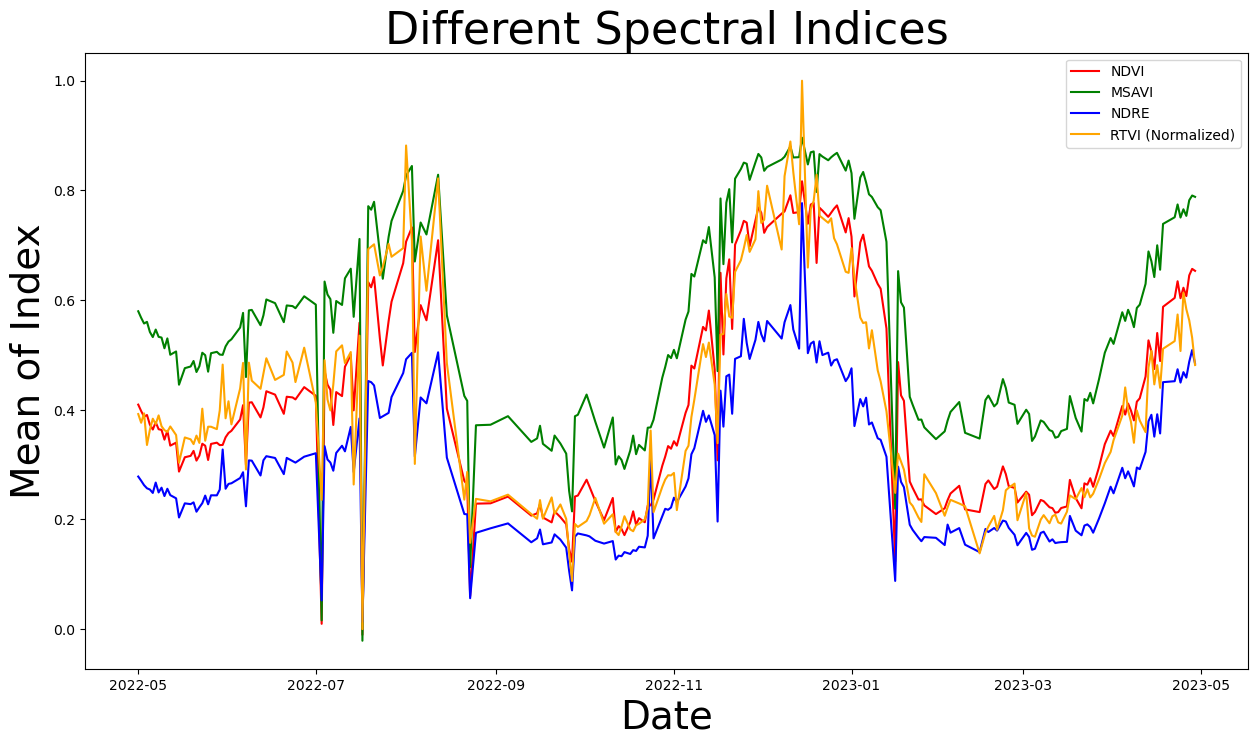

In [29]:
# Select a random field
field_id = np.random.choice(stats_df['field_id'].unique())
print(f"Visualizing the chart for field number {field_id}")

# Filter the data for the selected field where clouds are 0
series = stats_df[stats_df['field_id'] == field_id]

# Scale the RTVI mean
series["scaled rtvi mean"] = (series["rtvicore mean"] - series["rtvicore mean"].min()) / (series["rtvicore mean"].max() - series["rtvicore mean"].min())

# Plot the different spectral indices
pd.options.mode.chained_assignment = None 

fig, ax = plt.subplots(figsize=(15, 8))

series.plot(ax=ax, x="date", y="ndvi mean", color="red", label="NDVI")
series.plot(ax=ax, x="date", y="msavi mean", color= "green", label="MSAVI")
series.plot(ax=ax, x="date", y="ndre mean", color="blue", label="NDRE")
series.plot(ax=ax, x="date", y="scaled rtvi mean", color="orange", label="RTVI (Normalized)")

ax.set_title('Different Spectral Indices', fontsize=32)
ax.set_ylabel("Mean of Index", fontsize=28)
ax.set_xlabel("Date", fontsize=28)
ax.legend()

plt.show()

There might still be some anomalous data and noise in the time series.  We can make a function to remove statistical outlier and calculate a moving average

In [30]:
# Function to detect and remove outliers and then apply a moving average
def clean_and_smooth(series, outlier_threshold_percentile=95, moving_average_window=3):

    # Remove outliers
    differences = series.diff().abs()
    threshold = np.percentile(differences.dropna(), outlier_threshold_percentile)
    outliers = differences > threshold
    series[outliers] = np.nan
    series = series.ffill().bfill()
    
    # Apply moving average
    smoothed_series = np.convolve(series, np.ones(moving_average_window) / moving_average_window, mode='valid')
    
    # Pad the smoothed series to align with the original series length
    padding = (len(series) - len(smoothed_series)) // 2
    smoothed_series = np.pad(smoothed_series, (padding, len(series) - len(smoothed_series) - padding), mode='edge')#, constant_values=np.nan)
    
    return pd.Series(smoothed_series, index=series.index)

Let's make a function `clean_and_smooth` that removes outliers and bad data and then plots the multiple indices

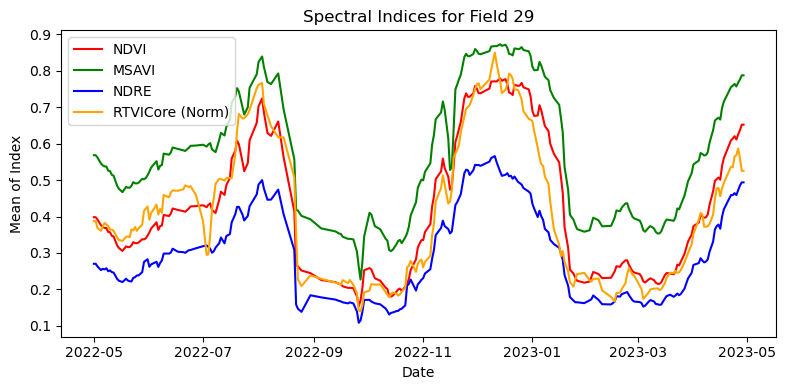

In [31]:
series = stats_df.loc[stats_df["field_id"] == field_id].copy()

# Example "clean and smooth" (pseudocode)
series["ndvi mean"] = clean_and_smooth(series["ndvi mean"])
series["msavi mean"] = clean_and_smooth(series["msavi mean"])
series["ndre mean"]  = clean_and_smooth(series["ndre mean"])

# Scale RTVI and smooth
series["scaled_rtvi"] = (series["rtvicore mean"] - series["rtvicore mean"].min()) / (
    series["rtvicore mean"].max() - series["rtvicore mean"].min()
)
series["scaled_rtvi"] = clean_and_smooth(series["scaled_rtvi"])

# Make a single figure just for these indices
plt.figure(figsize=(8, 4))
plt.plot(series["date"], series["ndvi mean"],     color="red",    label="NDVI")
plt.plot(series["date"], series["msavi mean"],    color="green",  label="MSAVI")
plt.plot(series["date"], series["ndre mean"],     color="blue",   label="NDRE")
plt.plot(series["date"], series["scaled_rtvi"],   color="orange", label="RTVICore (Norm)")

plt.title(f"Spectral Indices for Field {field_id}")
plt.xlabel("Date")
plt.ylabel("Mean of Index")
plt.legend()
plt.tight_layout()
plt.show()

Now that we have a function to create the chart, we can call it when a feature is clicked in the `ipyleaflet` map.  We can use this to explore the data for each field.

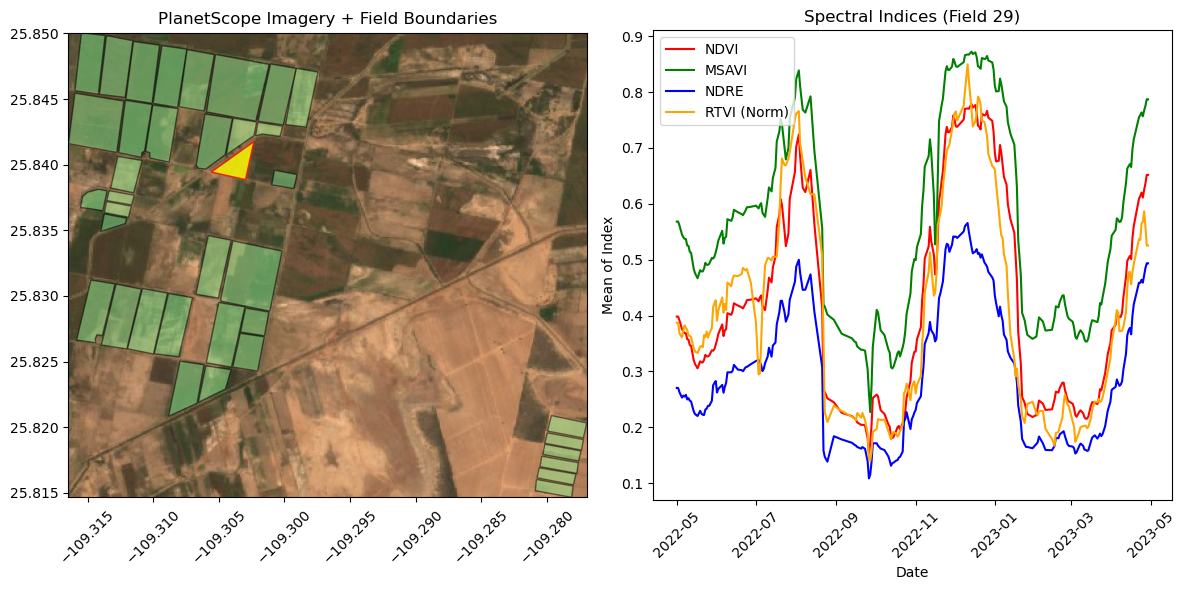

In [32]:
selected_poly = agriculture_fields.iloc[[field_id]]
other_polys   = agriculture_fields.drop(field_id)

selected_series = stats_df[stats_df["field_id"] == field_id].sort_values("date")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(image, extent=(minx, maxx, miny, maxy), origin='upper')

other_polys.plot(ax=ax1, color='lightgreen', edgecolor='black', alpha=0.5)

selected_poly.plot(ax=ax1, color='yellow', edgecolor='red', alpha=0.8)

ax1.set_aspect('equal')
ax1.ticklabel_format(useOffset=False, style='plain')
ax1.set_title("PlanetScope Imagery + Field Boundaries")
ax1.tick_params(axis='x', labelrotation=45)

ax2.plot(series["date"], series["ndvi mean"],    color="red",    label="NDVI")
ax2.plot(series["date"], series["msavi mean"],   color="green",  label="MSAVI")
ax2.plot(series["date"], series["ndre mean"],    color="blue",   label="NDRE")
ax2.plot(series["date"], series["scaled_rtvi"],  color="orange", label="RTVI (Norm)")

ax2.set_title(f"Spectral Indices (Field {field_id})")
ax2.set_xlabel("Date")
ax2.set_ylabel("Mean of Index")
ax2.legend()
ax2.tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()

## K-means Clustering of Time Series

Each field has a distinct curve, let's use `tslearn` to cluster similar time series.

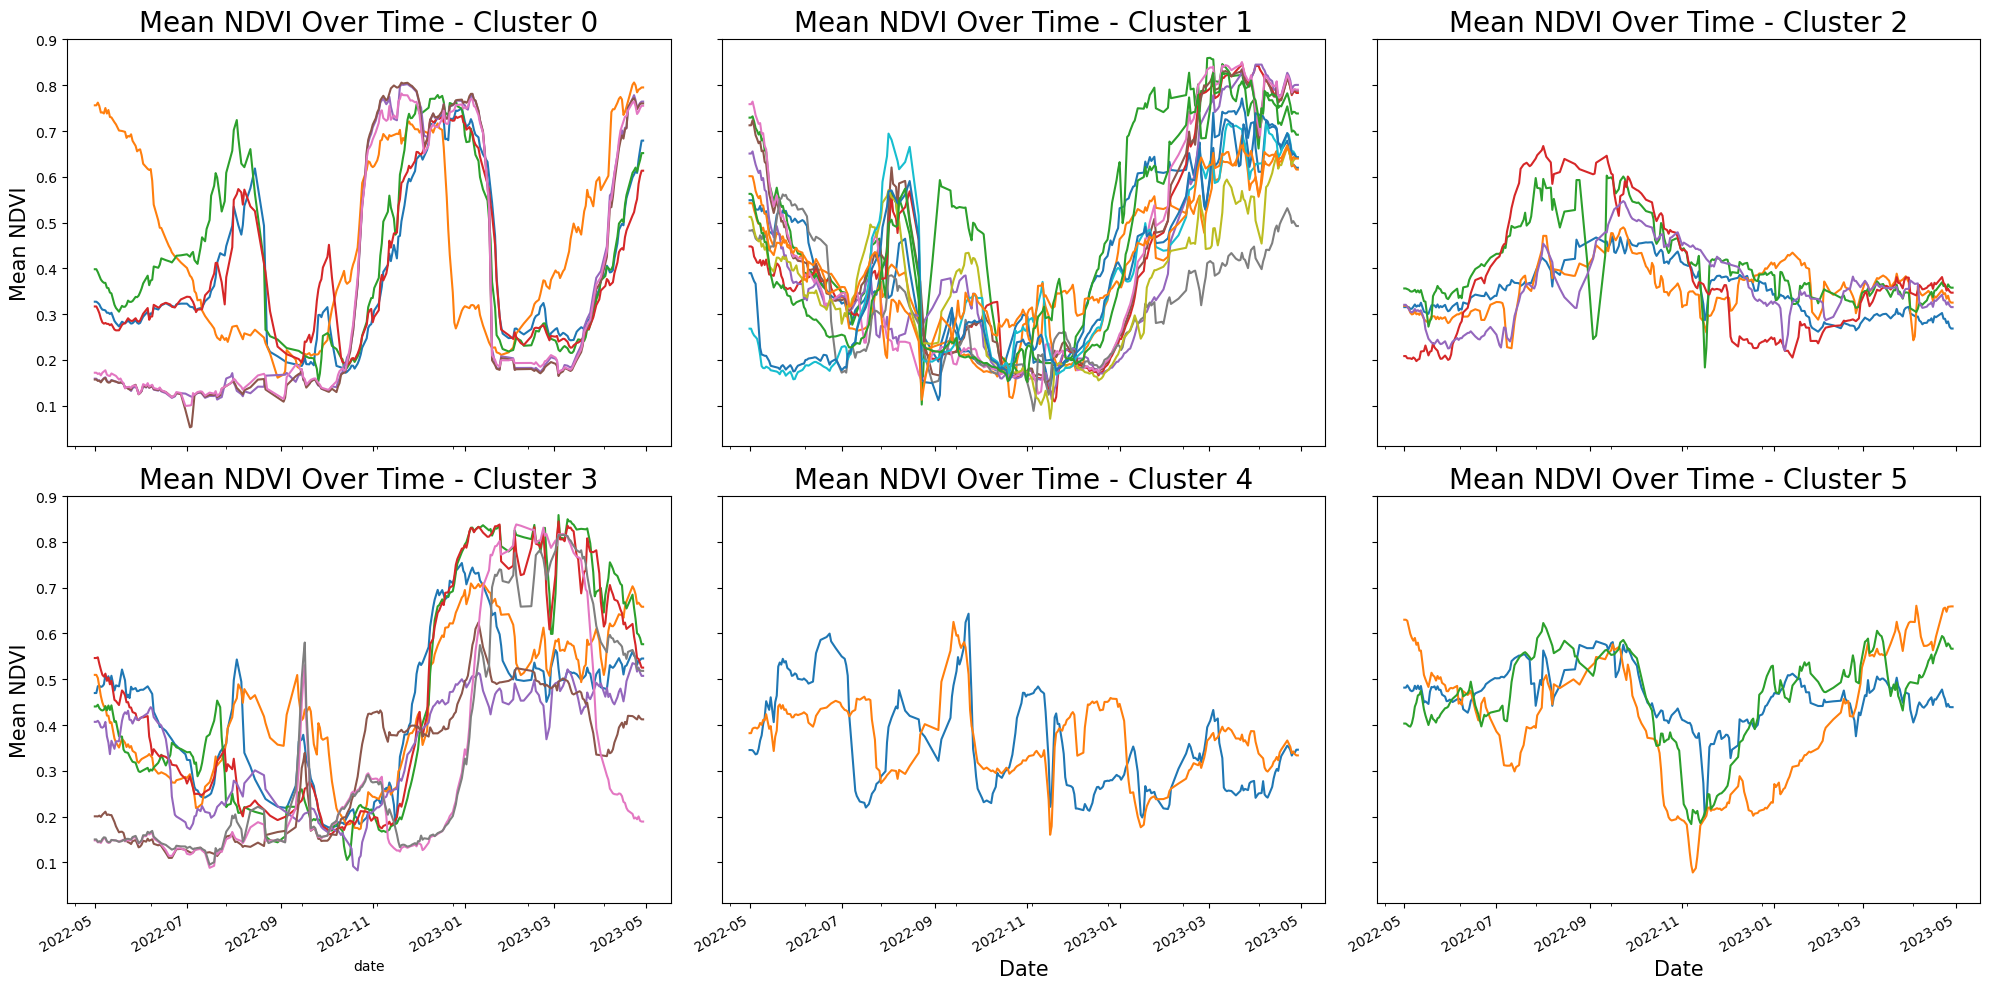

In [33]:
cleaned_smoothed_dfs= []
for field_id in stats_df['field_id'].unique():
    field_df = stats_df[stats_df['field_id'] == field_id].copy()
    field_df = field_df.sort_values(by='date')
    field_df['ndvi mean'] = clean_and_smooth(field_df['ndvi mean'])
    cleaned_smoothed_dfs.append(field_df)
cleaned_smoothed_df = pd.concat(cleaned_smoothed_dfs)

# Preprocess the data to ensure it is in the right format
cleaned_smoothed_df["date"] = pd.to_datetime(cleaned_smoothed_df["date"])
cleaned_smoothed_df = cleaned_smoothed_df.sort_values(by=["field_id", "date"])

# Create a pivot table to have time series data for each field
pivot_df = cleaned_smoothed_df.pivot(index="date", columns="field_id", values="ndvi mean")

# Fill missing values by forward filling and then backward filling
pivot_df = pivot_df.fillna(method='ffill').fillna(method='bfill')

# Convert the pivot table to a numpy array
time_series_data = pivot_df.T.values

# Normalize the time series data
scaler = TimeSeriesScalerMeanVariance(mu=0.5, std=0.25)
time_series_data_scaled = scaler.fit_transform(time_series_data)

# Apply K-means clustering
n_clusters = 6 # You can change the number of clusters based on your needs
kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", max_iter=100, n_init=5, verbose=False)
labels = kmeans.fit_predict(time_series_data_scaled)

# Add cluster labels to the dataframe
cleaned_smoothed_df['cluster'] = np.nan
agriculture_fields["cluster_id"] = np.nan
for idx, field_id in enumerate(pivot_df.columns):
    cleaned_smoothed_df.loc[cleaned_smoothed_df['field_id'] == field_id, 'cluster'] = labels[idx]
    agriculture_fields.loc[field_id, "cluster_id"] = labels[idx]

# Plot each cluster in its own subplot with 2 columns
n_rows = (n_clusters + 1) // 3
n_cols = n_clusters / n_rows

fig, axs = plt.subplots(n_rows, 3, figsize=(20, n_rows * 5), sharex=True, sharey=True)

for cluster_id in range(n_clusters):
    ax = axs[cluster_id // 3, cluster_id % 3]
    cluster_data = cleaned_smoothed_df[cleaned_smoothed_df['cluster'] == cluster_id]

    for fid in cluster_data['field_id'].unique():
        series = cleaned_smoothed_df[cleaned_smoothed_df["field_id"] == fid]
        series.plot(ax=ax, x="date", y="ndvi mean", legend=False)
    
    ax.set_title(f'Mean NDVI Over Time - Cluster {cluster_id}', fontsize=20)
    ax.set_ylabel("Mean NDVI", fontsize=15)
    if cluster_id >= n_clusters - 2:
        ax.set_xlabel("Date", fontsize=15)

plt.tight_layout()
plt.show()


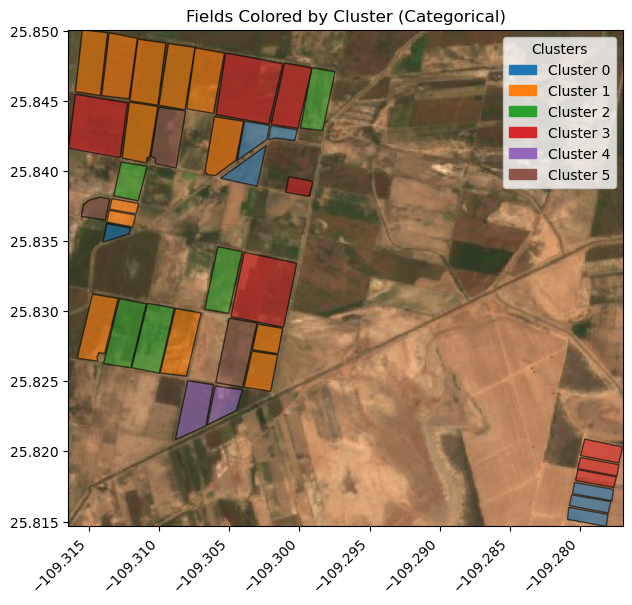

In [34]:
unique_clusters = sorted(agriculture_fields["cluster_id"].dropna().unique())

cmap = plt.get_cmap('tab10')

cluster_color_map = {}
for i, cluster in enumerate(unique_clusters):
    color = cmap(i % 10)
    cluster_color_map[cluster] = color

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image, extent=(minx, maxx, miny, maxy), origin='upper')

for cluster in unique_clusters:
    subset = agriculture_fields[agriculture_fields["cluster_id"] == cluster]
    subset.plot(ax=ax, facecolor=cluster_color_map[cluster], edgecolor='black', alpha=0.6)

patches = [
    mpatches.Patch(color=cluster_color_map[c], label=f'Cluster {int(c)}')
    for c in unique_clusters
]
ax.legend(handles=patches, title='Clusters', loc='upper right')

ax.set_aspect('equal')
ax.ticklabel_format(useOffset=False, style='plain')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
ax.set_title("Fields Colored by Cluster (Categorical)")

plt.show()


##### Area under the curve

We can use `np.trapz` to calculate the area under the time series curve for each field.

In practice you may want to calculate area under the curve within a specific time range, not the entire year.

Field 4.0 has the LOWEST area under the curve at 34.70.
Field 18.0 has the HIGHEST area under the curve at 90.76.


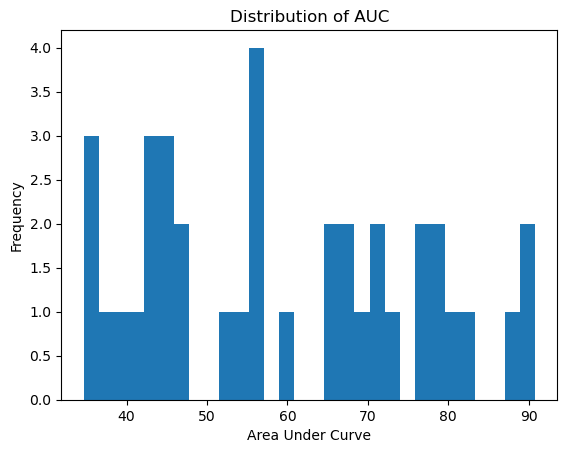

In [35]:
def compute_auc_by_field(df, year=2023, metric="ndvi mean"):
    """
    Calculate the Area Under the Curve (AUC) of 'metric' (e.g. NDVI) for each field,
    restricted to data within the specified 'year'.

    :param df: A DataFrame that must include:
               - 'field_id'
               - 'date' (datetime)
               - 'day_of_year'
               - a column with 'metric' (e.g. 'ndvi mean')
    :param year: The year of interest for calculating AUC
    :param metric: Column name in df whose values we integrate
    :return: A DataFrame with ['Field ID', 'AUC']
    """
    results = []
    
    for field_id in df['field_id'].unique():
        # Filter to a single field and the desired year
        series = df[(df['field_id'] == field_id) & (df['date'].dt.year == year)].copy()
        
        # If there's no data for that field/year, store NaN
        if series.empty:
            results.append([field_id, np.nan])
            continue
        
        # Ensure it's sorted by day_of_year
        series = series.sort_values(by='day_of_year')
        
        # Calculate AUC via trapezoidal rule
        auc_value = np.trapz(series[metric], x=series['day_of_year'])
        results.append([field_id, auc_value])
    
    return pd.DataFrame(results, columns=["Field ID", "AUC"])

# 1) Compute the AUC for each field
aucs_df = compute_auc_by_field(cleaned_smoothed_df, year=2023, metric="ndvi mean")

# 2) Identify the fields with min/max AUC
lowest_row = aucs_df.loc[aucs_df["AUC"].idxmin()]
highest_row = aucs_df.loc[aucs_df["AUC"].idxmax()]
min_max_rows = [lowest_row, highest_row]

print(f"Field {lowest_row['Field ID']} has the LOWEST area under the curve at {lowest_row['AUC']:.2f}.")
print(f"Field {highest_row['Field ID']} has the HIGHEST area under the curve at {highest_row['AUC']:.2f}.")

# 3) Plot a histogram of AUC values
aucs_df["AUC"].plot.hist(xlabel="Area Under Curve", title="Distribution of AUC", bins=30)
plt.show()


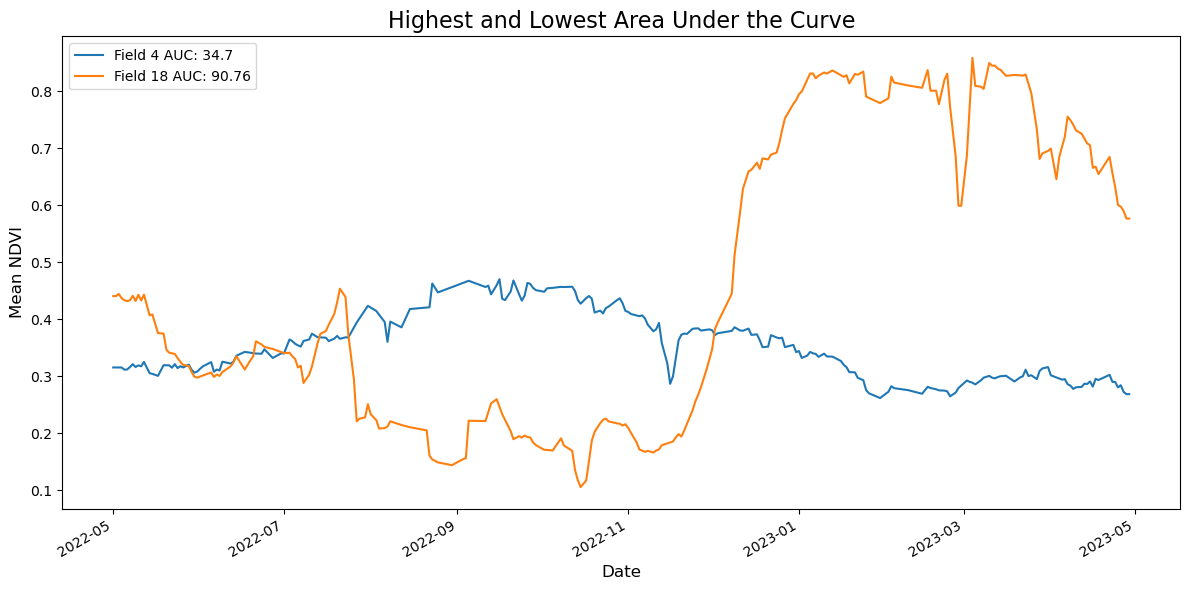

In [36]:
# Plot the highest and lowest AUC fields
fig, ax = plt.subplots(figsize=(12, 6))

for row in min_max_rows:
    fid = int(row["Field ID"])
    auc_value = row["AUC"]
    series = cleaned_smoothed_df[cleaned_smoothed_df["field_id"] == fid].copy()
    series = series.sort_values(by="day_of_year")
    series.plot(ax=ax, x="date", y="ndvi mean", legend=True, label=("Field " + str(fid) + " AUC: " + str(round(auc_value, 2))))

ax.set_title("Highest and Lowest Area Under the Curve", fontsize=16)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Mean NDVI", fontsize=12)
ax.legend()
plt.tight_layout()
plt.show()